In [1]:
"""
Name: example_analysis.ipynb
Authors: Stephan Meighen-Berger
Example how to construct a frequency analysis. Uses data generated by example analysis
"""

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import imageio
from tqdm import tqdm
import pickle

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [6]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [7]:
from itertools import groupby
def scramble_data(data, toprint=False):
    peaks = np.array([list(v) for k,v in groupby(data, key = lambda x: x != 0) if k != 0])
    number_of_peaks = len(peaks)
    number_of_elements = np.sum(np.array([len(it) for it in peaks]))
    total_number_of_elements = data.shape[0]
    number_of_pauses = total_number_of_elements - number_of_elements
    peak_order = np.arange(len(peaks))
    np.random.shuffle(peak_order)
    if toprint:
        print(number_of_pauses)
        print(number_of_peaks)
    peak_pos = np.random.choice(number_of_pauses, size=number_of_peaks, replace=False)
    peak_pos = np.sort(peak_pos)
    peak_diffs = np.diff(peak_pos)
    zero_arrs = np.array([
        np.zeros(peak_diff)
        for peak_diff in peak_diffs
    ])
    # Need to add 0
    to_add = np.zeros(number_of_pauses - np.sum(peak_diffs))
    list_form = zero_arrs.tolist()
    list_form.append(to_add)
    zero_arrs = np.array(list_form)
    splitting_base = np.array([
        np.concatenate((zero_arrs[i], peaks[i]))
        for i in peak_order
    ])
    new_data = np.array([item for sublist in splitting_base for item in sublist])
    return new_data

In [8]:
# Loading data
counter = 0
totals = []
for seed in np.arange(63):
    totals.append(pickle.load(open("../data/storage/vort_run_%d.p" % counter, "rb"))["data"])
    counter += 1
totals = np.array(totals)

In [9]:
totals = totals[:, 3000:]

In [10]:
totals.shape

(25, 3000)

In [10]:
totals[totals < 1000] = 0

In [11]:
# Scambling multiple times
scrambled_array = np.array([
    scramble_data(totals[i], toprint=False)
    for i in range(len(totals))
])
# The fft
fft_det_data = np.fft.fft(totals, norm='ortho', axis=1)
fft_freq_data = np.fft.fftfreq(totals[0].size, d=0.1)
fft_det_bkgrd = np.fft.fft(scrambled_array, norm='ortho', axis=1)
fft_freq_bkgrd = np.fft.fftfreq(scrambled_array[0].size, d=0.1)
# The mean and std
mean_arr_data = np.mean(np.abs(fft_det_data.real) / 1e7, axis=0, dtype=np.float64)
mean_arr_bkgrd = np.mean(np.abs(fft_det_bkgrd.real) / 1e7, axis=0, dtype=np.float64)
std_arr_bkgrd = np.std(np.abs(fft_det_bkgrd.real) / 1e7, axis=0, dtype=np.float64)

In [15]:
# Plotting standards
std_size = 3.
fontsize = 10.
lw=1.
h_length=0.2

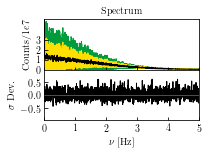

In [16]:
# --------------------------------------------------------------------------------------------------------------
# Frequency comparison
# --------------------------------------------------------------------------------------------------------------
# Absolute values
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
cut_off = np.argmax(fft_freq_data)
ax1.fill_between(fft_freq_bkgrd[:cut_off],
                 smooth(mean_arr_bkgrd.real[:cut_off] - 2. * std_arr_bkgrd[:cut_off] * mean_arr_bkgrd.real[:cut_off], 1),
                 smooth(mean_arr_bkgrd.real[:cut_off] + 2. * std_arr_bkgrd[:cut_off] * mean_arr_bkgrd.real[:cut_off], 1),
                 color='#009C3B', alpha=1.)
ax1.fill_between(fft_freq_bkgrd[:cut_off],
                 smooth(mean_arr_bkgrd.real[:cut_off] - std_arr_bkgrd[:cut_off] * mean_arr_bkgrd.real[:cut_off], 1),
                 smooth(mean_arr_bkgrd.real[:cut_off] + std_arr_bkgrd[:cut_off] * mean_arr_bkgrd.real[:cut_off], 1),
                 color='#FFDF00', alpha=1.)
# ax1.plot(fft_freq_bkgrd[:cut_off],
#          mean_arr_bkgrd.real[:cut_off],
#          lw=lw, color='r')
ax1.plot(fft_freq_data[:cut_off],
         smooth(mean_arr_data.real[:cut_off], 1),
         lw=lw, color='k')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
# ax1.set_xlabel(r'$\nu\;[\mathrm{Hz}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Counts} / 1e7$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.set_yticks((0., 1., 2., 3.))
ax1.set_ylim(0., 5.)
ax1.set_title(r"$\mathrm{Spectrum}$", fontsize=fontsize)
# ax1.set_xlim(0., 5.)
# --------------------------------------------------------------------------------------------------------------
# Difference
ax2.plot(fft_freq_data[:cut_off],
         (((mean_arr_data.real[:cut_off] - mean_arr_bkgrd.real[:cut_off]) / std_arr_bkgrd[:cut_off])),
         lw=lw, color='k')
ax2.hlines(0., xmin=0., xmax=5., color='r', lw=lw, zorder=100)
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlabel(r'$\nu\;[\mathrm{Hz}]$', fontsize=fontsize)
ax2.set_ylabel(r'$\sigma\;\mathrm{Dev.}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax2.text(2.5, 2.1, r"$2\sigma$", fontsize=fontsize)
ax2.set_yticks((0., -0.5, 0.5))
ax2.set_ylim(-1, 1)
ax2.set_xlim(0., 5.)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [17]:
figure.savefig(PICS + "MC_FFT_3.pdf",
               bbox_inches='tight')